In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd

In [2]:
df = pd.read_csv("shop.csv", encoding="latin1")
df = pd.concat([df.iloc[:,0], df.iloc[:,1::2]], axis = 'columns')
df.iloc[50,1] = 13

store_dict = { 1: 'Lidl', 2: 'Rewe', 3: 'Aldi', 4: 'Edeka' }
type_dict = {1:"Apple", 2:"Banana", 3:"Tomatoes", 4:"Potatoes", 5:"Flour", 6:"Rice", 7:"Milk", 8:"Butter", 9:"Eggs", 10:"Chicken"}
area_dict = {1:"Mitte", 2:"Schoneberg", 3:"Neukooln", 4:"Kreuzberg", 5:"Friedrichshain", 6:"Prenzlauer Berg", 7:"Tiergarten",
             8:"Alt-Trepof", 9:"Wedding", 10:"Gesundbrunnen", 11:"Moabit", 12:"Rummelsburg", 13:"Lichtenberg" }

x = []

for i in range(10): 
    for j in range(len(df.iloc[:,i+2:i+5].values)): 
        for k in (df.iloc[:,i+2:i+5].values[j]): 
            if not np.isnan(k):
                x.append([i+1, df.iloc[j,0], int(df.iloc[j,1]), k])
               
data = {
    'N' : len(x),
    'Prices': np.array(x)[:,3].tolist(),
    'Area': list(map(int, np.array(x)[:,2].tolist())),
    'Store': list(map(int,np.array(x)[:,1].tolist())),
    'Product': list(map(int,np.array(x)[:,0].tolist()))
}


In [3]:
stan_code = """
data {  
    int<lower=1> N;
    real<lower=0> Prices[N];  
    int<lower=1, upper=13> Area[N];
    int<lower=1, upper=4> Store[N];
    int<lower=1, upper=10> Product[N];
}

parameters {  
    real base[10];
    real mul_store[4];
    real mul_area[13];
    real sigma;
}

model {
    sigma ~ gamma(1,1);
    
    for (i in 1:N){
        base[Product[i]] ~ cauchy(1.5, 2);
        mul_store[Store[i]] ~ cauchy(1.5, 2);
        mul_area[Area[i]] ~ cauchy(1.5, 2);
        
        Prices[i] ~ normal(base[Product[i]] * mul_area[Area[i]] * mul_store[Store[i]], sigma);
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d10d2591745905c0c6a05542da5b173f NOW.


In [10]:
fit = stan_model.sampling(data=data, chains=4, iter=25000, seed = 69)
fit

Inference for Stan model: anon_model_d10d2591745905c0c6a05542da5b173f.
4 chains, each with iter=25000; warmup=12500; thin=1; 
post-warmup draws per chain=12500, total post-warmup draws=50000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base[1]        1.29  3.2e-4   0.06   1.17   1.25   1.29   1.33   1.41  33775    1.0
base[2]        1.17  3.1e-4   0.06   1.06   1.13   1.17   1.21   1.29  35525    1.0
base[3]        1.08  3.1e-4   0.06   0.96   1.04   1.07   1.11   1.19  35500    1.0
base[4]        0.96  3.2e-4   0.06   0.83   0.91   0.96    1.0   1.08  38919    1.0
base[5]        1.35  3.4e-4   0.07   1.22    1.3   1.35   1.39   1.48  36797    1.0
base[6]         1.7  3.8e-4   0.07   1.57   1.66    1.7   1.75   1.84  32282    1.0
base[7]        1.84  3.9e-4   0.07   1.71   1.79   1.83   1.88   1.97  28125    1.0
base[8]        1.48  3.5e-4   0.06   1.36   1.44   1.48   1.52    1.6  31892    1.0
base[9]        1.12  3.1e-4   0.06   1.01   1.08   

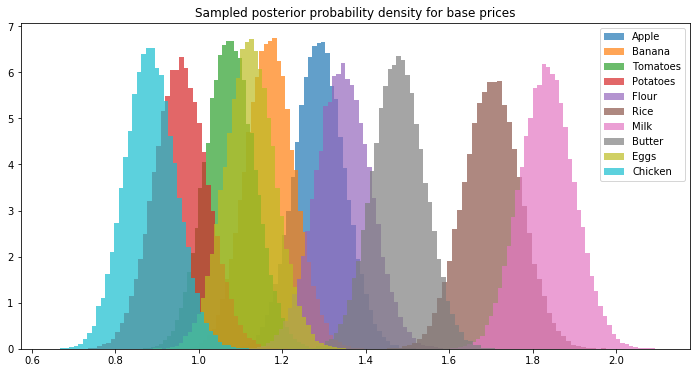

In [16]:
posterior = fit.extract()

plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for base prices')
for i in range(10):
    plt.hist(posterior['base'][:,i],bins=50, density = True, alpha = 0.7, label = type_dict[i+1]) 
    
plt.legend()
plt.show()

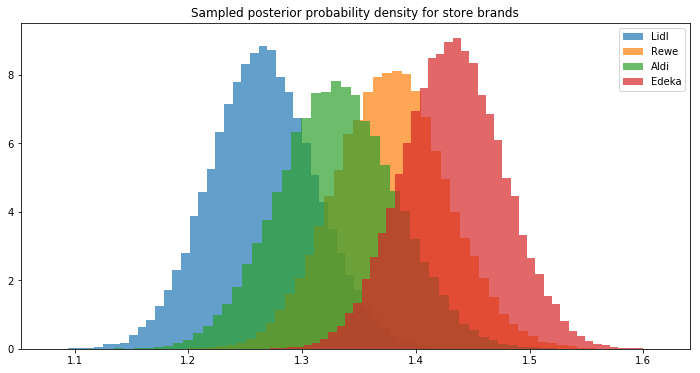

In [12]:
plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for store brands')
for i in range(4):
    plt.hist(posterior['mul_store'][:,i],bins=50, density=True, alpha = 0.7, label = store_dict[i+1]) 
    
plt.legend()
plt.show()

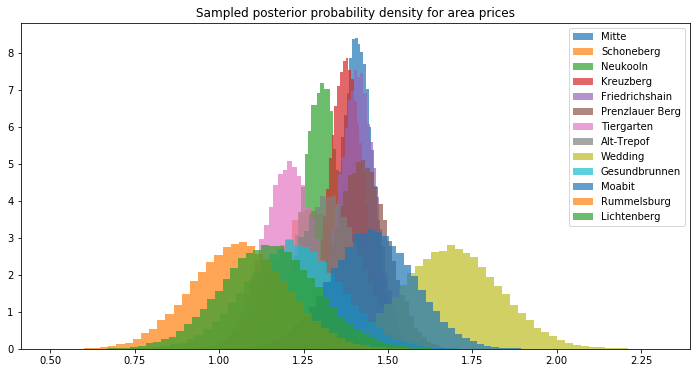

In [13]:
plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for area prices')
for i in range(13):
    plt.hist(posterior['mul_area'][:,i], bins=50, density=True, alpha = 0.7, label = area_dict[i+1]) 
    
plt.legend()
plt.show()

array([1.09028564, 1.18425755, 1.17617156, ..., 1.18665916, 1.14188163,
       1.03319059])